# User-based recommender
User-based recommenders are like having a knowledgeable friend who knows your preferences inside out and suggests things tailored specifically to your taste. These recommenders analyse your past interactions, such as previous purchases or ratings, to find users with similar preferences and recommend items they have enjoyed. By leveraging the wisdom of like-minded users, user-based recommenders aim to provide personalised recommendations that align with your individual interests. They excel at capturing the nuances of your preferences and offering suggestions that are more tailored to your unique taste. However, it's important to keep in mind that user-based recommenders may have limitations when there is limited data available or when users' preferences change over time.

---
## 1.&nbsp;Import libraries and files 💾
We'll be using the same book ratings csv as in the Popularity and Item-based recommender notebooks.

In [1]:
import pandas as pd

In [2]:
url = 'https://drive.google.com/file/d/1yFwxNVF0MuAsiFTAZMfoVGt1nIOatByg/view?usp=sharing'
path = 'https://drive.google.com/uc?id='+url.split('/')[-2]
df = pd.read_csv(path)

In [9]:
import pandas as pd

def gd_path(file_id):
    return f"https://drive.google.com/uc?export=download&id={file_id}"


files_id = {
    'links': "1GR8IQ2OXsFI8MNmv4bQIV1XXkq7n56MB",
    'movies': "1PDuCaAhhVTRLYdftMr6VqX23crMqB_qg",
    'rating': "1F4_-HBPBSySMjxdGxlykWVjvVn9AJ0BS",
    'tags': "1bH6HhZfqLT0JGqYxyRLQAk7UIpnYj4x4"
    }


links = pd.read_csv(gd_path(files_id['links']), sep=",")
movies = pd.read_csv(gd_path(files_id['movies']), sep=",")
rating = pd.read_csv(gd_path(files_id['rating']), sep=",")
tags = pd.read_csv(gd_path(files_id['tags']), sep=",")

In [56]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [25]:
rating.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


---
## 2.&nbsp;The Surprise library 🎉
[Surprise](https://surpriselib.com/) is a versatile and user-friendly library that provides a wide range of collaborative filtering algorithms and evaluation metrics for building recommendation systems. With Surprise, we can effortlessly implement user-based recommenders.

However, it's worth noting that while we will be focusing on Surprise as our tool of choice, it's important to understand that there are alternative ways to build user-based recommenders, including manual implementation of algorithms. By introducing you to Surprise, we aim to showcase the potential and convenience of using dedicated machine learning libraries, but it's always beneficial to have a comprehensive understanding of the underlying concepts and techniques, such as what we learnt manually building an item-based recommender.

Install Surprise:
 - Since Colab doesn't have surprise pre-installed, you'll need to perform this step at the beginning of each session on Colab
 - If you're working locally, you'll only need to install once

In [15]:
#%%capture
#pip install scikit-surprise

Import the necessary modules:

In [16]:
from surprise import Reader, Dataset, KNNBasic, accuracy
from surprise.model_selection import train_test_split

### 2.1.&nbsp;Preparing the data
Preparing data is a crucial step in building a model with Surprise. The Reader class acts as a guide for the library to understand the structure and format of the data. It provides a convenient way to parse and interpret the dataset by specifying the rating scale and other relevant information.

In addition to the Reader, Surprise employs the Dataset class, which serves as a container for our data. This class enables us to organise, manipulate, and analyse the dataset effectively. By utilising the Dataset class, we can conveniently load data from various sources, such as CSV files or Pandas DataFrames, and transform it into a format suitable for Surprise. The Dataset class plays a crucial role in facilitating seamless integration between the data and the library, ensuring that the data is prepared and structured in a way that allows us to apply collaborative filtering algorithms and generate meaningful recommendations.

When working with the Surprise library, it is important to note that the expected file format assumes a single rating per line. Each line in the file should adhere to the structure below to ensure compatibility with the library.

> user | item | rating | [timestamp]

In [27]:
data = rating.drop(columns='timestamp')

In [28]:
data

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Create a surprise dataset from the DataFrame

In [29]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(data, reader)

Split the dataset into train and test sets:

In [30]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=142)

### 2.2.&nbsp;Making a model to test
In this section, we will demonstrate the process of constructing a recommender and evaluating its effectiveness. It is advisable to experiment with diverse models and various parameters to effectively determine the optimal configuration for your final recommender system.

When it comes to building recommendation models using surprise, a wealth of options and parameters are at your disposal. Surprise provides a wide range of collaborative filtering algorithms, such as Singular Value Decomposition (SVD), K-Nearest Neighbors (KNN), and Non-negative Matrix Factorization (NMF), each with its own set of configurable parameters. Whether you want to experiment with different similarity measures, adjust the number of neighbors to consider, or fine-tune regularisation parameters, surprise offers a comprehensive toolkit to explore and create models that cater to your specific requirements.

In this tutorial, we will guide you through the process of creating a simple KNN model. You might notice that `sim_options`  behaves similarly to the `param_grid` we used in our supervised machine learning project. If you're eager to dive deeper into the topic, we encourage you to explore the documentation and discover more about the various options and configurations available.

In [31]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

knn = KNNBasic(sim_options=sim_options)

Train the algorithm on the training set:

In [32]:
knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Make predictions on the test set:

In [33]:
predictions = knn.test(testset)

#### 2.2.1.&nbsp;Exploring the predictions
The predictions provide us with a list of named tuples. These named tuples are specifically created to hold the results of a prediction. They are packaged within a class primarily for documentation and printing purposes. The named tuple comprises the following parameters:

- `uid`: Represents the raw user id
- `iid`: Represents the raw item id
- `r_ui`: Denotes the true rating provided by the user
- `est`: Represents the estimated rating calculated by the model
- `details`: Stores additional information about the prediction, which can be valuable for further analysis. It provides a space to include any relevant details that might enhance the understanding or interpretation of the prediction results

In [34]:
predictions[:5]

[Prediction(uid=380, iid=2085, r_ui=3.0, est=3.5191062895722083, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=367, iid=513, r_ui=4.0, est=2.9999999999999996, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=570, iid=349, r_ui=4.0, est=3.7123899526005637, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=288, iid=2018, r_ui=3.0, est=3.391371971142089, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid=446, iid=266, r_ui=2.0, est=3.4014122408648797, details={'actual_k': 40, 'was_impossible': False})]

To enhance readability, let's convert this into a DataFrame, making it more visually appealing and easier to interpret.

In [35]:
predictions_df = pd.DataFrame(predictions, columns=["raw_user_id", "raw_item_id", "actual_user_rating", "estimated_user_rating", "details"])
predictions_df.head()

,raw_user_id,raw_item_id,actual_user_rating,estimated_user_rating,details
0,380,2085,3.0,3.519106,"{'actual_k': 30, 'was_impossible': False}"
1,367,513,4.0,3.000000,"{'actual_k': 2, 'was_impossible': False}"
2,570,349,4.0,3.712390,"{'actual_k': 40, 'was_impossible': False}"
3,288,2018,3.0,3.391372,"{'actual_k': 29, 'was_impossible': False}"
4,446,266,2.0,3.401412,"{'actual_k': 40, 'was_impossible': False}"


#### 2.2.2.&nbsp;Evaluation
Evaluating recommendation systems is a crucial step in assessing their performance and effectiveness. While the ideal approach is to conduct online evaluations with real users, we often face limitations that confine us to offline evaluation methods.

Surprise offers a range of evaluation metrics, including mean average error (MAE), root mean square error (RMSE), and fraction of concordant pairs (FCP). These metrics enable us to quantitatively measure the accuracy and performance of recommenders by comparing predicted ratings with actual user ratings. However, it is important to note that there are alternative methods for offline evaluation beyond these popular metrics.

##### 2.2.2.1.&nbsp;Mean Absolute Error
Mean Absolute Error (MAE) is a simple way to find out how good or bad our recommender system is at guessing the ratings that users give to books. It helps us understand how "off" our guesses are from the real ratings. To calculate MAE, we first find the difference between the actual rating and the estimated rating for each user and book pair. Then, we take the absolute value of these differences (which means we ignore negative signs) and find the average of all these absolute differences.

Here's an example using the first row of the above DataFrame:

1. Actual rating: 10.0, Estimated rating: 8.5
2. Difference: 10.0 - 8.5 = 1.5
3. Absolute difference: |1.5| = 1.5

We repeat this process for all rows and find the average of the absolute differences. That's our Mean Absolute Error! The smaller the MAE, the better our recommender system is at guessing the ratings.

In [36]:
accuracy.mae(predictions)

MAE:  0.7466


0.7465676186021254

In the context of a recommender system, a Mean Absolute Error (MAE) of 1.3811 means that, on average, the predictions made by the system are about 1.3811 units away from the actual ratings given by users. This appears to be pretty good, all of our ratings are normally only about 1 point away from where they should be.

##### 2.2.2.2.&nbsp;Root Mean Square Error
Root Mean Squared Error (RMSE) is another way to find out how good our recommender system is at guessing the ratings users give to books. Like MAE, it helps us understand how "off" our guesses are from the real ratings. To calculate RMSE, we first find the difference between the actual rating and the estimated rating for each user and book pair. Then, we square these differences and find the average of all these squared differences. Finally, we take the square root of this average.

Here's an example using the first row of your dataframe:

1. Actual rating: 10.0, Estimated rating: 8.5
2. Difference: 10.0 - 8.5 = 1.5
3. Squared difference: 1.5 * 1.5 = 2.25

We repeat this process for all rows and find the average of the squared differences, and then take the square root of that average. That's our Root Mean Squared Error! The smaller the RMSE, the better our recommender system is at guessing the ratings. RMSE is more sensitive to large errors than MAE because it squares the differences, so it "punishes" bigger errors more than MAE does.

In [37]:
accuracy.rmse(predictions)

RMSE: 0.9706


0.9706404973871133

##### 2.2.2.3.&nbsp;Fraction of Concordant Pairs
Fraction of Concordant Pairs (FCP) is a way to find out how good our recommender system is at ranking books by comparing pairs of actual ratings and estimated ratings. It helps us understand if our recommender system is correctly ranking books for users. To calculate FCP, we first create pairs of actual ratings and estimated ratings for each user. Then, we count the number of pairs where the relative order of the ratings is the same. This means that if a user rated book A higher than book B, our recommender system should also estimate that the user would rate book A higher than book B. These pairs are called "concordant pairs".

Now, we'll divide the number of concordant pairs by the total number of pairs. That's our Fraction of Concordant Pairs! The higher the FCP, the better our recommender system is at ranking books for users. Unlike MAE and RMSE, which focus on the differences between actual and estimated ratings, FCP focuses on the relative order of the ratings.

In [38]:
accuracy.fcp(predictions)

FCP:  0.6685


0.6684847446082518

> **Note:** the combination of a low Fraction of Concordant Pairs (FCP) and a good Root Mean Square Error (RMSE) should raise our awareness that the RMSE alone may not accurately reflect the effectiveness of the recommender. This observation prompts us to delve deeper into the analysis and explore additional factors. To conduct a comprehensive evaluation of the recommender, it is advisable to combine both manual and pre-made evaluation methods.

##### 2.2.2.4.&nbsp;The manual approach
In our exploration of supervised machine learning, we examined a histogram of errors and a scatterplot of errors. Here, we will employ a similar approach. We'll begin by analysing a histogram of errors, but we'll replace the scatterplot with a box plot. Given the discrete nature of the data, using a scatterplot results in dots forming lines and overlapping, providing limited insight into density. To gain a better understanding of density and variance, we'll utilise a box plot instead.

###### Histogram of errors
To generate a histogram of errors and a scatterplot of errors, we must initially calculate the difference between the actual and predicted ratings — this difference is referred to as the "error."

In [39]:
predictions_df["difference"] = predictions_df["actual_user_rating"] - predictions_df["estimated_user_rating"]

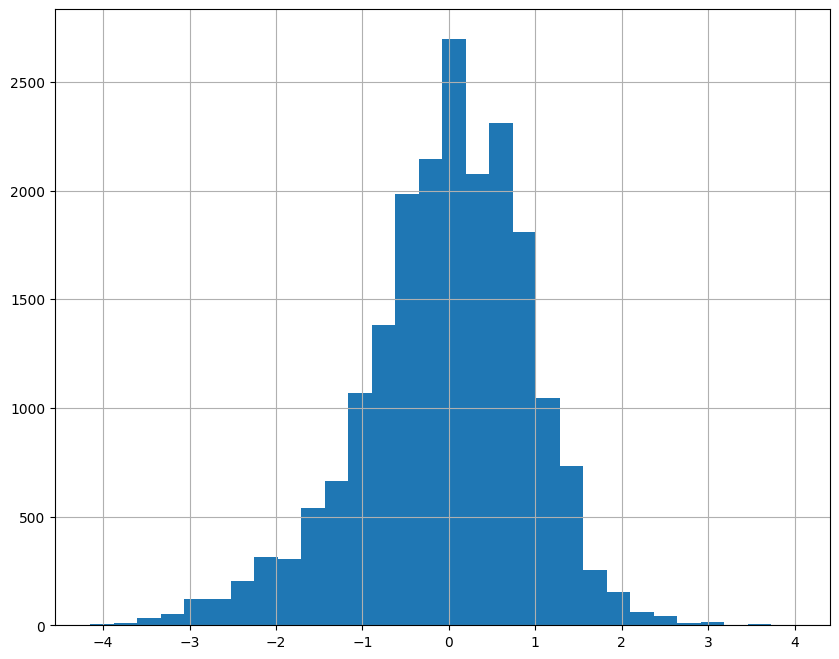

In [40]:
predictions_df["difference"].hist(bins=30,
                                  figsize=(10, 8));

Our model displays a left skew, suggesting that it tends to overestimate ratings to a greater extent than underestimating them. It could be intriguing to experiment with various parameters and observe their impact on this behavior. However, it doesn't tell us a great deal about the discord between our FCP and RMSE, so let's take a look at the boxplot.

###### Boxplot of errors

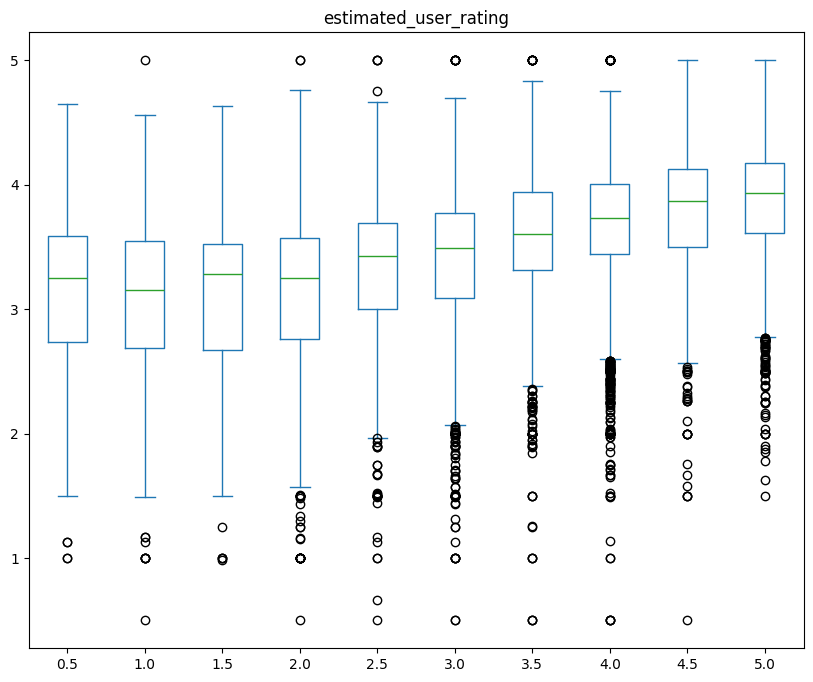

In [41]:
predictions_df.plot(kind='box',
                    column='estimated_user_rating',
                    by='actual_user_rating',
                    figsize=(10, 8));

Irrespective of the actual rating, it is evident that the median predicted rating for each category consistently centres around 8. This observation sheds light on why we obtained a seemingly good Root Mean Squared Error (RMSE), despite the recommender system performing poorly in predicting low values. As we discovered during our data exploration in the popularity recommender notebook, most users tend to provide generous ratings, with the majority falling within the range of 7-9. It appears that our recommender system is consistently predicting a rating of 8, aligning with the abundance of ratings clustered around this value. While this may contribute to a favourable RMSE, it indicates a lack of nuance and adaptability in our recommender system, as it tends to generalise and treat all items uniformly.

### 2.3.&nbsp; Making a model to use
After identifying your preferred model and parameters, you can construct a recommender using the entire dataset.

To illustrate the process of creating a recommender using Surprise, we'll make a quick example of how to get the top n recommendations for a user. Feel encouraged to modify and tailor the code to suit your specific requirements.

Our objective is to generate predictions for items that the user has not yet rated, leveraging the patterns observed from the items they have rated. To achieve this, we utilise the `build_full_trainset()` method. This method constructs a comprehensive training set encompassing all user-item ratings.

In [42]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

full_train = data.build_full_trainset()
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


When using `build_full_trainset`, we pair it with `build_anti_testset()`. This method creates a test set for predicting items that users haven't rated yet. It simulates scenarios where the recommendation system suggests new items to users.

In [43]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

Next, let's create a function that will provide the top n recommendations for a specified user.

In [44]:
def get_top_n(predictions, user_id, n=10):

  user_recommendations = []

  # Iterate through each prediction tuple
  for uid, iid, true_r, est, _ in predictions:
    # Check if the user ID matches the target user
    if user_id == uid:
      # Append item_id and estimated_rating to the user_recommendations list
      user_recommendations.append((iid, est))
    else:
      # Skip to the next prediction if user ID doesn't match
      continue

  # Sort the user_recommendations list based on estimated_rating in descending order
  ordered_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)

  # Get the top n predictions from the ordered_recommendations
  ordered_recommendations_top_n = ordered_recommendations[:n]

  return ordered_recommendations_top_n

Let's see if the function works 👀

In [48]:
rating.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [65]:
user_id = 100
n = 10

top_n = get_top_n(predictions, user_id, n)
top_n

[(6021, 5),
 (3303, 5),
 (173619, 5),
 (3939, 5),
 (98279, 5),
 (3851, 5),
 (26849, 5),
 (147328, 5),
 (5181, 5),
 (47736, 5)]

Success! 🎉 Now, our final task is to match the ISBNs in the tuples with their respective book titles and other relevant information.

In [64]:
# Creating a DataFrame from the top_n tuples with columns 'book_isbn' and 'estimated_rating'
tuples_df = pd.DataFrame(top_n, columns=["movieId", "estimated_rating"])

# Creating a copy of the original DataFrame with duplicate 'book_isbn' entries removed
reduced_df = movies.drop_duplicates(subset='movieId').copy()

# Merging the tuples_df with the reduced_df based on 'book_isbn', retaining only the matching rows
tuples_df_expanded = tuples_df.merge(reduced_df, on="movieId", how='left')

# Selecting specific columns from the merged DataFrame to include in the final result
tuples_df_expanded = tuples_df_expanded[['movieId', 'title', 'genres']]

# Displaying the expanded DataFrame with relevant book information
tuples_df_expanded

,movieId,title,genres
0,6021,"American Friend, The (Amerikanische Freund, De...",Crime|Drama|Mystery|Thriller
1,3303,Black Tar Heroin: The Dark End of the Street (...,Documentary
2,173619,Fugitives (1986),Comedy|Crime
3,3939,Slumber Party Massacre II (1987),Horror
4,98279,"Fantastic Fear of Everything, A (2012)",Comedy
5,3851,I'm the One That I Want (2000),Comedy
6,26849,"Stand, The (1994)",Adventure|Drama|Fantasy|Horror|Sci-Fi
7,147328,The Adventures of Sherlock Holmes and Dr. Wats...,Crime
8,5181,Hangar 18 (1980),Action|Sci-Fi|Thriller
9,47736,"Chump at Oxford, A (1940)",Comedy


In [79]:
def predictions_list(user_id_2, n_2):

    user_id = user_id_2
    n = n_2
    
    top_n = get_top_n(predictions, user_id, n)
    # Creating a DataFrame from the top_n tuples with columns 'movieId' and 'estimated_rating'
    tuples_df = pd.DataFrame(top_n, columns=["movieId", "estimated_rating"])

    # Creating a copy of the original DataFrame with duplicate 'movieId' entries removed
    reduced_df = movies.drop_duplicates(subset='movieId').copy()

    # Merging the tuples_df with the reduced_df based on 'movieId', retaining only the matching rows
    tuples_df_expanded = tuples_df.merge(reduced_df, on="movieId", how='left')

    # Selecting specific columns from the merged DataFrame to include in the final result
    tuples_df_expanded = tuples_df_expanded[['movieId', 'title', 'genres']]
    return tuples_df_expanded
    

In [84]:
predictions_list(500 ,10)

,movieId,title,genres
0,6021,"American Friend, The (Amerikanische Freund, De...",Crime|Drama|Mystery|Thriller
1,3303,Black Tar Heroin: The Dark End of the Street (...,Documentary
2,173619,Fugitives (1986),Comedy|Crime
3,3939,Slumber Party Massacre II (1987),Horror
4,98279,"Fantastic Fear of Everything, A (2012)",Comedy
5,3851,I'm the One That I Want (2000),Comedy
6,26849,"Stand, The (1994)",Adventure|Drama|Fantasy|Horror|Sci-Fi
7,44943,9/11 (2002),Documentary
8,147328,The Adventures of Sherlock Holmes and Dr. Wats...,Crime
9,5181,Hangar 18 (1980),Action|Sci-Fi|Thriller


---
## 3.&nbsp;Challenge: build a surprise recommender 😃
Use the skills that you've learnt in this notebook to build a recommender for your movie dataset using surprise. Use the [surprise docs](https://surpriselib.com/) to try out other recommenders and other parameters. Be creative and have fun 😃